In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import seaborn as sns; sns.set_style("ticks")

### Read table, columns, define data

In [3]:
#I think I will use the table from NED "Groups-and-clusters-NED-HS.csv" for now to select groups and clusters, 
#and if I need more information on the future I try to understand the table from Kourkchi & Tully (2017)
#Remembering that the problem I am having is that when doing the crossmatch between the two tables, it seems to have
#an offset between the coordinates of the clusters

In [2]:
clusters = pd.read_csv("../Groups-and-Clusters/Groups-and-clusters-NED-HS.csv", 
                       usecols=["RA", "DEC", "Redshift", "Object Name", "Magnitude and Filter"])

In [3]:
ra_cl = clusters["RA"]
dec_cl = clusters["DEC"]
z_cl = clusters["Redshift"]
cl_name = clusters["Object Name"]
mag_cl = clusters["Magnitude and Filter"]

In [4]:
mags_cl_float = []
for i in np.asarray(mag_cl):
    if i != '     ': mag = i[:4]
    else: mag = np.nan    
    mags_cl_float.append(float(mag))
mags_cl_float = np.asarray(mags_cl_float) 

In [12]:
mask_cl = ~np.isnan(mags_cl_float) & (ra_cl < ra_max) & (ra_cl > ra_min) & (dec_cl > dec_min) & (dec_cl < dec_max)

In [8]:
table = pd.read_csv("tables_photometric/Hydra-Centaurus-Gaia-Crossmatch-probgal&isoarea.csv", 
                    usecols=["RA", "DEC", "PROB_GAL", "zml", "r_petro", "g_petro"])

In [10]:
ra = table["RA"]
dec = table["DEC"]
probgal = table["PROB_GAL"]
zml = table["zml"]
rpetro = table["r_petro"]
gpetro = table["g_petro"]

In [11]:
mlim = 18
ra_max = 180
ra_min = 150
dec_min = -48
dec_max = -15

#I used to use the cut in photo-z as (zml > 0.005) & (zml < 0.03)
mask = (rpetro < mlim) & (ra < ra_max) & (ra > ra_min) & (dec > dec_min) & (dec < dec_max)

### Use KNN to estimate the density 

In [13]:
x = np.deg2rad(ra[mask]) #like longitude
y = np.deg2rad(dec[mask]) #like latitude

xbin_size = 200
ybin_size = 200

xbins=xbin_size*1j
ybins=ybin_size*1j

xx, yy = np.mgrid[x.min():x.max():xbins, y.min():y.max():ybins]

#### This is from https://github.com/astroML/astroML/blob/main/astroML/density_estimation/density_estimation.py, with the only difference that I am changing the BallTree() metric from Minkowski to Haversine

In [14]:
#AstroML.KNeighborsDensity
"""
Tools for density estimation
See also:
- sklearn.mixture.gmm : gaussian mixture models
- sklearn.neighbors.KernelDensity : Kernel Density Estimation (version 0.14+)
- astroML.density_estimation.XDGMM : extreme deconvolution
- scipy.spatial.gaussian_kde : a gaussian KDE implementation
"""
import numpy as np
from scipy import special
from sklearn.base import BaseEstimator
from sklearn.neighbors import BallTree


def n_volume(r, n):
    """compute the n-volume of a sphere of radius r in n dimensions"""
    return np.pi ** (0.5 * n) / special.gamma(0.5 * n + 1) * (r ** n)


class KNeighborsDensity(BaseEstimator):
    """K-neighbors density estimation
    Parameters
    ----------
    method : string
        method to use.  Must be one of ['simple'|'bayesian'] (see below)
    n_neighbors : int
        number of neighbors to use
    Notes
    -----
    The two methods are as follows:
    - simple:
        The density at a point x is estimated by n(x) ~ k / r_k^n
    - bayesian:
        The density at a point x is estimated by n(x) ~ sum_{i=1}^k[1 / r_i^n].
    See Also
    --------
    KDE : kernel density estimation
    """
    def __init__(self, method='bayesian', n_neighbors=10):
        if method not in ['simple', 'bayesian']:
            raise ValueError("method = %s not recognized" % method)

        self.n_neighbors = n_neighbors
        self.method = method

    def fit(self, X):
        """Train the K-neighbors density estimator
        Parameters
        ----------
        X : array_like
            array of points to use to train the KDE.  Shape is
            (n_points, n_dim)
        """
        self.X_ = np.atleast_2d(X)

        if self.X_.ndim != 2:
            raise ValueError('X must be two-dimensional')

        self.bt_ = BallTree(self.X_, metric="haversine")

        return self

    def eval(self, X):
        """Evaluate the kernel density estimation
        Parameters
        ----------
        X : array_like
            array of points at which to evaluate the KDE.  Shape is
            (n_points, n_dim), where n_dim matches the dimension of
            the training points.
        Returns
        -------
        dens : ndarray
            array of shape (n_points,) giving the density at each point.
            The density will be normalized for metric='gaussian' or
            metric='tophat', and will be unnormalized otherwise.
        """
        X = np.atleast_2d(X)
        if X.ndim != 2:
            raise ValueError('X must be two-dimensional')

        if X.shape[1] != self.X_.shape[1]:
            raise ValueError('dimensions of X do not match training dimension')

        dist, ind = self.bt_.query(X, self.n_neighbors, return_distance=True)

        k = float(self.n_neighbors)
        ndim = X.shape[1]

        if self.method == 'simple':
            return k / n_volume(dist[:, -1], ndim)

        elif self.method == 'bayesian':
            # XXX this may be wrong in more than 1 dimension!
            return (k * (k + 1) * 0.5 / n_volume(1, ndim)
                    / (dist ** ndim).sum(1))
        else:
            raise ValueError("Unrecognized method '%s'" % self.method)


In [15]:
def knn2D(x, y, K, xbins=200j, ybins=200j, **kwargs): 
    """Build 2D Nearest-Neighbor density estimate (KNN)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    knd = KNeighborsDensity(method="bayesian", n_neighbors=K)
    knd.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = knd.eval(xy_sample)
    return xx, yy, np.reshape(z, xx.shape)

In [16]:
K = 200
xx, yy, zz = knn2D(x, y, K=K, xbins=xbins, ybins=ybins)

In [29]:
#Some clusters and galaxies in the region of Hydra Supercluster we got from a random website
cl_names = np.array(["N3393", "ABELL 1060", "N3054", "N3087", "Antlia", "N3347", 
                     "N3250", "N3256", "N3263", "ABELL S0639", "ABELL S0631", "ABELL S0628"])

cl_ras = np.array([162.09, 159.17, 148.61, 149.78, 157.51, 160.69, 156.63, 156.96, 157.30, 160.14, 152.41, 151.53])

cl_decs = np.array([-25.16, -27.52, -25.70, -34.22, -35.32, -36.35, -39.94, -43.90, -44.12, -46.19, -39.95, -39.74])

mask = cl_ras > 150

In [17]:
cl_names_mem = np.array(["Hydra", "Antlia", "AS0648", "AS0639", "A3443"])
cl_ra_mem = np.array([159.17417, 157.51461, 162.2862, 160.14115, 155.28746])
cl_dec_mem = np.array([-27.52444, -35.32341, -42.84817, -46.19478, -33.71903])
cl_z_mem = np.array([0.012, 0.009767, 0.057987, 0.0211, 0.0758])
cl_radii_mem = np.array([1.5744, 0.5, 0.5, 0.5, 0.5]) #deg
cl_radii_mem_kpc = np.array([1372, 800, 800, 800, 800]) #kpc
cl_id_mem = np.array([0, 1, 2, 3, 4])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


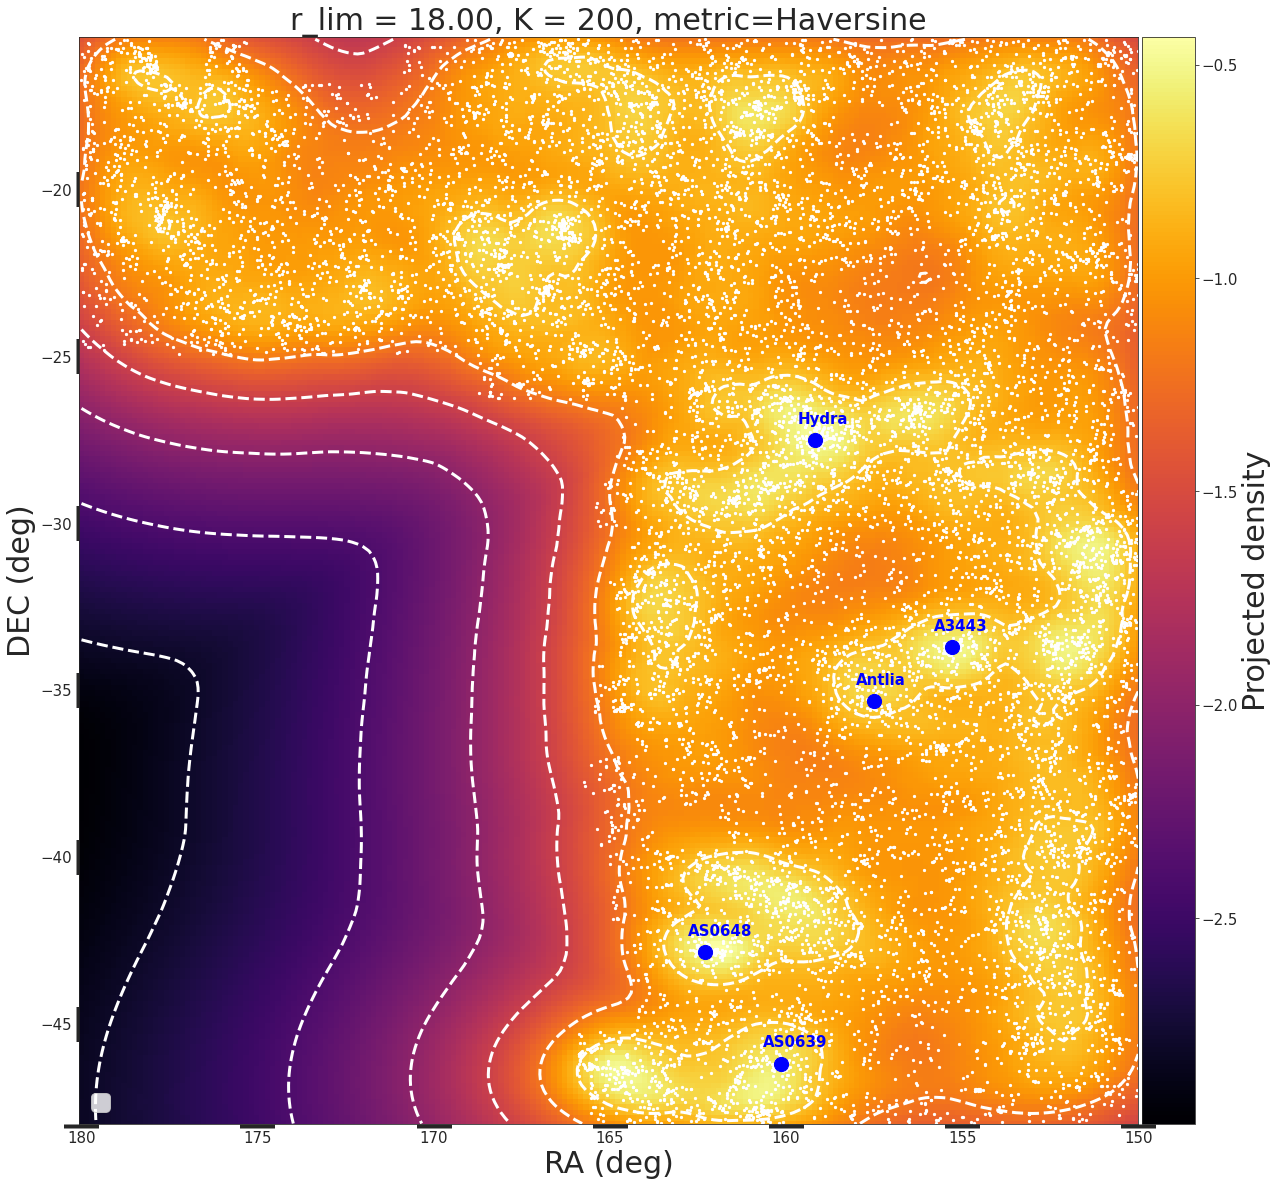

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

conversion_factor = np.rad2deg(1)**2 * K

fontsize = 30
labelsize = 15

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
sc1 = ax.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), np.log10(zz/conversion_factor), cmap='inferno')
ax.contour(np.rad2deg(xx), np.rad2deg(yy), np.log10(zz/conversion_factor), colors='white', levels=6, extend='min', linewidths=3)
ax.scatter(np.rad2deg(x), np.rad2deg(y), s=5, color='white')
ax.set_ylabel("DEC (deg)", fontsize=fontsize)
ax.set_xlabel("RA (deg)", fontsize=fontsize)
ax.set_title("r_lim = {:.2f}, K = {:1d}, metric=Haversine".format(mlim, K), fontsize=fontsize)

divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="Projected density", fontsize=fontsize)
cbar.ax.tick_params(labelsize=labelsize)

ax.legend(fontsize=fontsize*0.8)
ax.xaxis.set_tick_params(labelsize=labelsize, width=35)
ax.yaxis.set_tick_params(labelsize=labelsize, width=35)

dx = 0.5
# for ra_i, dec_i, text in zip(cl_ras[mask], cl_decs[mask], cl_names[mask]):
#     ax.scatter(ra_i, dec_i, marker='o', s = 200, color="black", zorder=3)
#     if (text == "N3256") | (text == "AS0631"): 
#         ax.text(ra_i-dx, dec_i-dx, s=text, fontsize=labelsize, fontweight='bold', color='black', zorder=4)
#     else: 
#         ax.text(ra_i+dx, dec_i+dx, s=text, fontsize=labelsize, fontweight='bold', color='black', zorder=4)
        
for ra_i, dec_i, text in zip(cl_ra_mem, cl_dec_mem, cl_names_mem):
    ax.scatter(ra_i, dec_i, marker='o', s = 200, color="blue", zorder=3)  
    ax.text(ra_i+dx, dec_i+dx, s=text, fontsize=labelsize, fontweight='bold', color='blue', zorder=4)

# for ra_i, dec_i, text in zip(ra_cl[mask_cl], dec_cl[mask_cl], cl_name[mask_cl]):
#     ax.scatter(ra_i, dec_i, marker='o', s = 200, color="black", zorder=3)  
#     ax.text(ra_i+dx, dec_i+dx, s=text, fontsize=labelsize, fontweight='bold', color='black', zorder=4)
    
ax.set_ylim(-48)
ax.set_xlim(150)
ax.invert_xaxis()

### Doing KNN by hand

In [32]:
def haversine(x1, y1, x2, y2):
    '''
    Calculate the distance between points (x1, y1) and (x2, y2) using haversine metric
    
    Basically, x1 and x2 are the right ascencions, and y1 and y2 are the declinations
    '''
    
    return 2*np.arcsin(np.sqrt(np.sin((x2-x1)/2)**2 + np.cos(x1)*np.cos(x2)*np.sin((y2-y1)/2)**2))

In [155]:
#By using a loop and calculating distances using the Haversine distance as defined above
zz_knn = np.zeros_like(zz)
k = 10
ndim = 2
for i in range(0, 200):
    for j in range(0, 200):
        dist = haversine(xx[i, j], yy[i, j], x, y)
        dk = np.sort(dist)[:k-1]
        zz_knn[i, j] = (k * (k + 1) * 0.5 / n_volume(1, ndim) / (dk ** ndim).sum())

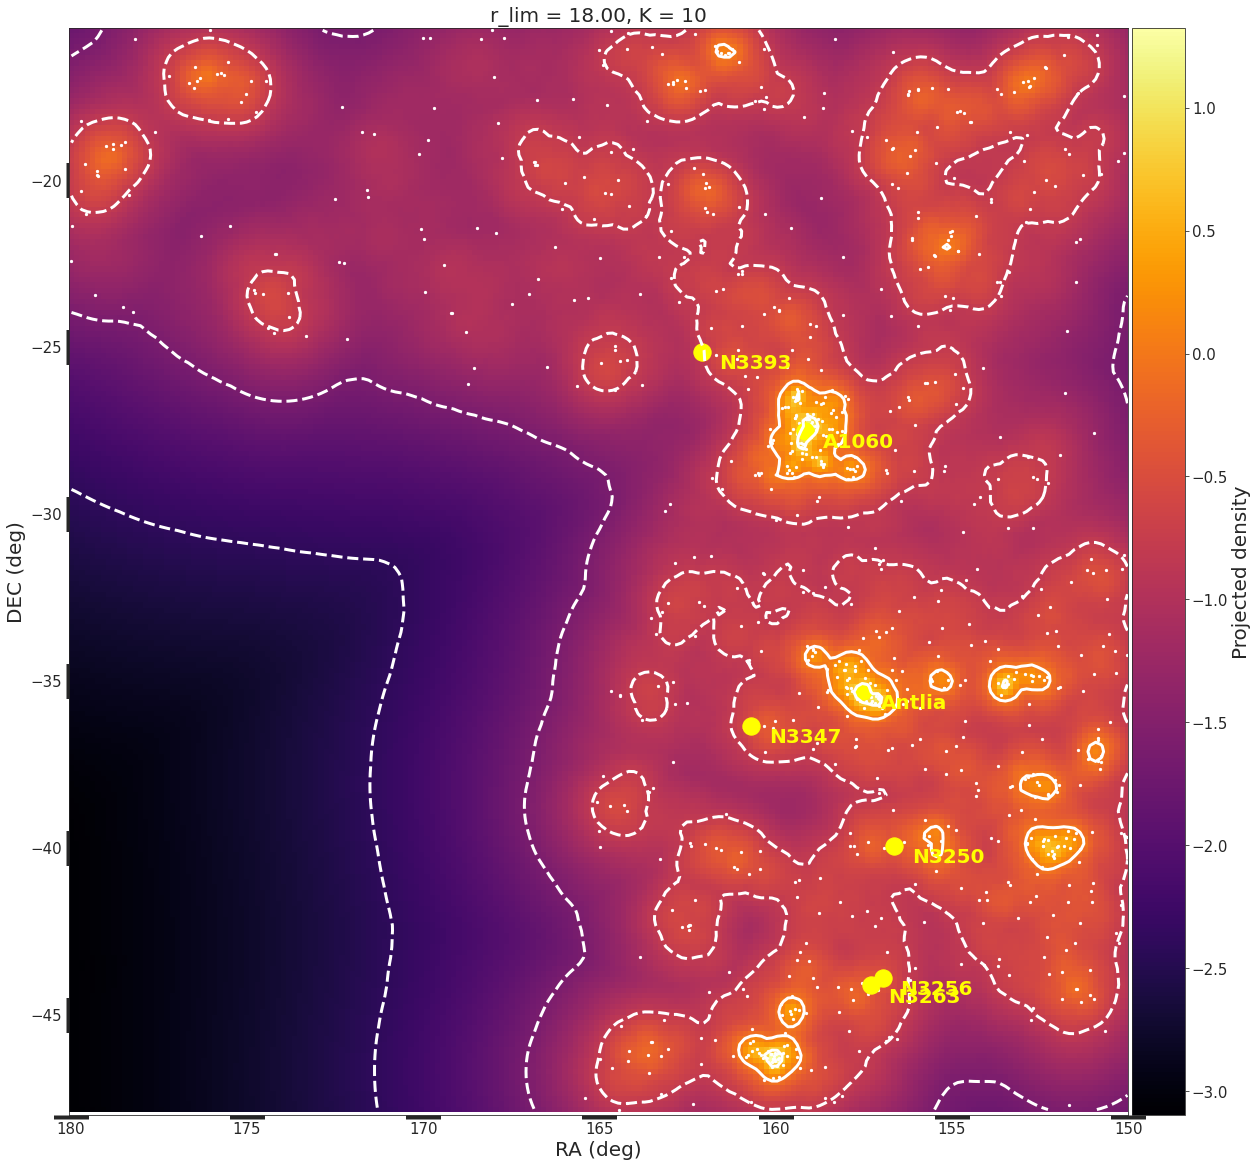

In [157]:
conversion_factor = np.rad2deg(1)**2 * k

fontsize = 20
labelsize = 15

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
sc1 = ax.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), np.log10(zz_knn/conversion_factor), cmap='inferno')
ax.contour(np.rad2deg(xx), np.rad2deg(yy), np.log10(zz_knn/conversion_factor), colors='white', levels=6, extend='min', linewidths=3)
ax.scatter(np.rad2deg(x), np.rad2deg(y), s=5, color='white')
ax.set_ylabel("DEC (deg)", fontsize=fontsize)
ax.set_xlabel("RA (deg)", fontsize=fontsize)
ax.set_title("r_lim = {:.2f}, K = {:1d}".format(mlim, k), fontsize=fontsize)

# ax.scatter(x=ra_s[mask_s], y=dec_s[mask_s], s=50, color="black", marker="d")

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="Projected density", fontsize=fontsize)
cbar.ax.tick_params(labelsize=labelsize)

# ax.legend(fontsize=fontsize*0.8)
ax.xaxis.set_tick_params(labelsize=labelsize, width=35)
ax.yaxis.set_tick_params(labelsize=labelsize, width=35)

dx = 0.5
for ra_i, dec_i, text in zip(cl_ras[mask], cl_decs[mask], cl_names[mask]):
    ax.scatter(ra_i, dec_i, marker='o', s = 300, color="yellow")
    ax.text(ra_i-dx, dec_i-dx, s=text, fontsize=fontsize, fontweight='bold', color='yellow')
    
ax.set_ylim(-48)
ax.set_xlim(150)
ax.invert_xaxis()

In [168]:
#By using the BallTree method to calculate distances

k = 10

xy_train  = np.vstack([y, x]).T
xy_train_ = np.atleast_2d(xy_train)

xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
xy_sample_ = np.atleast_2d(xy_sample)


if xy_train_.ndim != 2:
    raise ValueError('xy_train must be two-dimensional')
    
if xy_sample_.ndim != 2:
    raise ValueError('xy_sample_ must be two-dimensional')

if xy_train_.shape[1] != xy_sample_.shape[1]:
            raise ValueError('dimensions of xy_sample do not match training dimension')

        
bt_ = BallTree(xy_train_, metric="haversine")

dist, ind = bt_.query(xy_sample_, k, return_distance=True)

ndim = xy_sample_.shape[1]
dens = (k * (k + 1) * 0.5 / n_volume(1, ndim)/ (dist ** ndim).sum(1))

zz_knn_BallTree = np.reshape(dens, xx.shape)

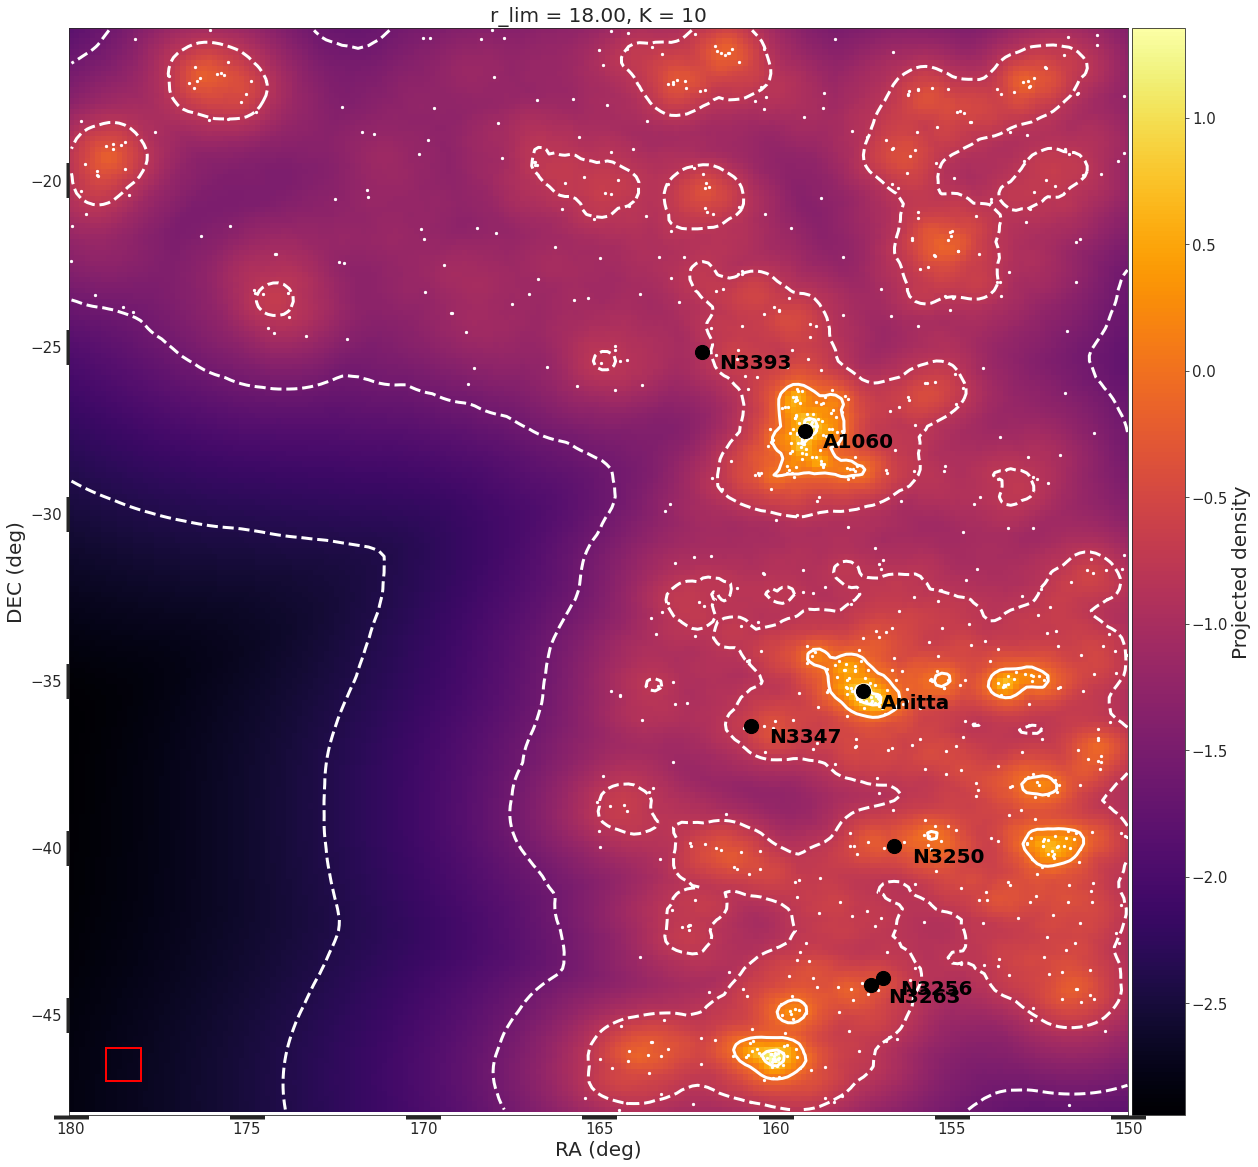

In [174]:
conversion_factor = np.rad2deg(1)**2 * k

fontsize = 20
labelsize = 15

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
sc1 = ax.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), np.log10(zz_knn_BallTree/conversion_factor), cmap='inferno')
ax.contour(np.rad2deg(xx), np.rad2deg(yy), np.log10(zz_knn_BallTree/conversion_factor), colors='white', levels=6, extend='min', linewidths=3)
ax.scatter(np.rad2deg(x), np.rad2deg(y), s=5, color='white')
ax.set_ylabel("DEC (deg)", fontsize=fontsize)
ax.set_xlabel("RA (deg)", fontsize=fontsize)
ax.set_title("r_lim = {:.2f}, K = {:1d}".format(mlim, k), fontsize=fontsize)

# ax.scatter(x=ra_s[mask_s], y=dec_s[mask_s], s=50, color="black", marker="d")

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="Projected density", fontsize=fontsize)
cbar.ax.tick_params(labelsize=labelsize)

# ax.legend(fontsize=fontsize*0.8)
ax.xaxis.set_tick_params(labelsize=labelsize, width=35)
ax.yaxis.set_tick_params(labelsize=labelsize, width=35)

dx = 0.5
for ra_i, dec_i, text in zip(cl_ras[mask], cl_decs[mask], cl_names[mask]):
    ax.scatter(ra_i, dec_i, marker='o', s = 200, color="black", zorder=3)
    ax.text(ra_i-dx, dec_i-dx, s=text, fontsize=fontsize, fontweight='bold', color='black', zorder=4)

    
rect = patches.Rectangle((178, -47), 1, 1, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
    
ax.set_ylim(-48)
ax.set_xlim(150)
ax.invert_xaxis()

### Method to remove borders

In [30]:
zz_nan = np.zeros_like(zz)
nan_cut = 0.015
zz_nan[(zz/conversion_factor) < nan_cut] = np.nan

In [49]:
zz_t = np.zeros_like(zz)
border_width = np.deg2rad(1.5)

for i in range(0, 200):
    for j in range(0, 200):
        dist = haversine(xx[i, j], yy[i, j], xx, yy)
        if np.isnan(zz_nan[i, j]) == True: zz_t[dist < border_width] = np.nan
            
zz_without_borders = zz + zz_t

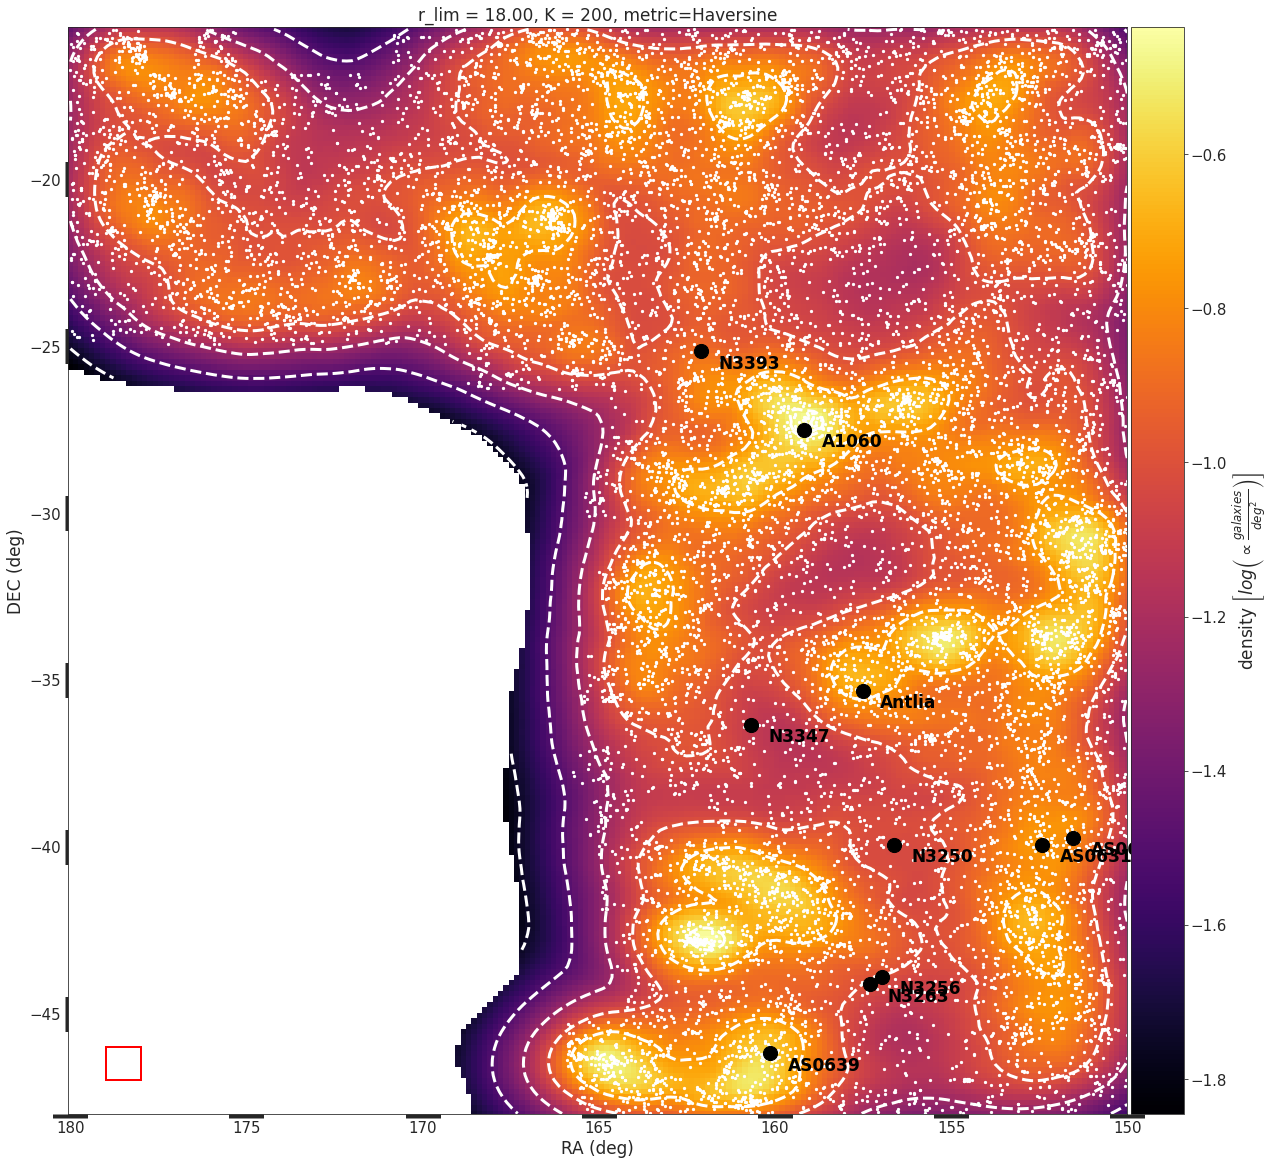

In [50]:
conversion_factor = np.rad2deg(1)**2 * K

fontsize = 17
labelsize = 15

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
sc1 = ax.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), np.log10(zz_without_borders/conversion_factor), cmap='inferno')
ax.contour(np.rad2deg(xx), np.rad2deg(yy), np.log10(zz_without_borders/conversion_factor), colors='white', levels=6, extend='min', linewidths=3)
ax.scatter(np.rad2deg(x), np.rad2deg(y), s=5, color='white')
ax.set_ylabel("DEC (deg)", fontsize=fontsize)
ax.set_xlabel("RA (deg)", fontsize=fontsize)
ax.set_title("r_lim = {:.2f}, K = {:1d}, metric=Haversine".format(mlim, K), fontsize=fontsize)

# ax.scatter(x=ra_s[mask_s], y=dec_s[mask_s], s=50, color="black", marker="d")

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label=r"density $\left[ log \left( \propto \frac{galaxies}{deg^2} \right) \right ]$", fontsize=fontsize)
cbar.ax.tick_params(labelsize=labelsize)

# ax.legend(fontsize=fontsize*0.8)
ax.xaxis.set_tick_params(labelsize=labelsize, width=35)
ax.yaxis.set_tick_params(labelsize=labelsize, width=35)

dx = 0.5
for ra_i, dec_i, text in zip(cl_ras[mask], cl_decs[mask], cl_names[mask]):
    ax.scatter(ra_i, dec_i, marker='o', s = 200, color="black", zorder=3)
    ax.text(ra_i-dx, dec_i-dx, s=text, fontsize=fontsize, fontweight='bold', color='black', zorder=4)
    
# ax.scatter(ra_gal1, dec_gal1, marker='o', s = 200, color="black", zorder=3)
# ax.text(ra_gal1+2*dx, dec_gal1+dx, s="PGC 610839", fontsize=labelsize, fontweight='bold', color='black', zorder=4)

# ax.scatter(ra_gal2, dec_gal2, marker='o', s = 200, color="black", zorder=3)
# ax.text(ra_gal2+2*dx, dec_gal2+dx, s="PGC 655154", fontsize=labelsize, fontweight='bold', color='black', zorder=4)

    
rect = patches.Rectangle((178, -47), 1, 1, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
    
    
ax.set_ylim(-48)
ax.set_xlim(150)
ax.invert_xaxis()

#### Estimate the background as the mode of the density

Peak of the distribution after correcting for borders = 62774.591


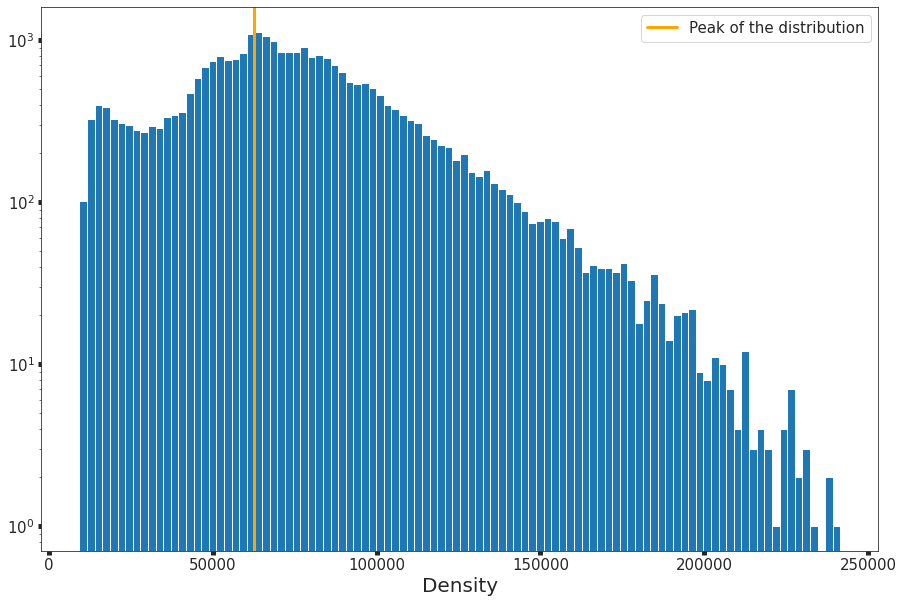

In [124]:
labelsize = 15

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)

dens = zz_without_borders.flatten()[~np.isnan(zz_without_borders.flatten())]
hist = ax.hist(dens, bins=100)

mean = np.mean(dens)
median = np.median(dens)
mode1 = hist[1][np.argmax(hist[0])]
mode2 = 2.5*median - 1.5*mean

# ax.axvline(mode2, color="red", label="2.5*median - 1.5*mean", lw=3)
ax.axvline(mode1, color="orange", label="Peak of the distribution", lw=3)
ax.set_xlabel("Density", fontsize=20)

ax.xaxis.set_tick_params(labelsize=labelsize, width=5)
ax.yaxis.set_tick_params(labelsize=labelsize, width=5)

ax.set_yscale("log")

plt.legend(fontsize=15)

background_density = mode1
print("Peak of the distribution after correcting for borders = {:.3f}".format(background_density))

#### Estimate average density around Hydra and compare with background density (this was an attempt to derive a prior to the membership method)

In [106]:
#Defining the center of Hydra (in degress)
ra0 = 159.17
dec0 = -27.524

#Defining the radius of 1R200 around the center (in degrees)
#R200 = 1.4Mpc + scale of 0.247 Kpc/" ==> radius = 1.5744º
radius = 1.5744

#Redshift of Hydra
zagl_hydra = 0.012

In [120]:
dists = np.rad2deg(haversine(xx, yy, np.deg2rad(ra0), np.deg2rad(dec0)))

In [129]:
hydra_radius = 5*radius
mask_hydra = dists < hydra_radius
mean_density = np.sum(zz[mask_hydra]) / (np.pi * hydra_radius**2)

In [130]:
background_density / mean_density

0.017658084297701132

#### I tried to apply KDE here instead of a simple histogram, but it was not so successfull

In [52]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [53]:
def generate_data(seed=17):
    # Fix the seed to reproduce the results
    rand = np.random.RandomState(seed)
    x = []
    dat = rand.lognormal(0, 0.3, 1000)
    x = np.concatenate((x, dat))
    dat = rand.normal(3, 1, 1000)
    x = np.concatenate((x, dat))
    return x

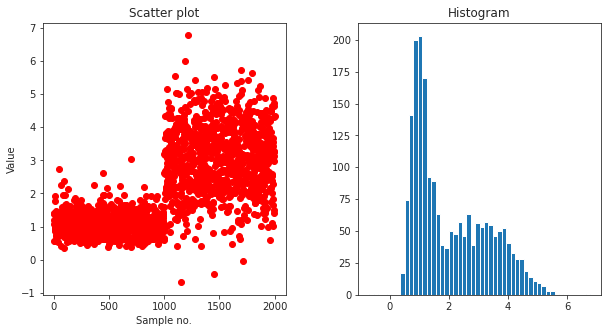

In [64]:
# x_train = generate_data()[:, np.newaxis]
x_train = generate_data().reshape(-1, 1)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt.subplot(121)
plt.scatter(np.arange(len(x_train)), x_train, c='red')
plt.xlabel('Sample no.')
plt.ylabel('Value')
plt.title('Scatter plot')
plt.subplot(122)
plt.hist(x_train, bins=50)
plt.title('Histogram')
fig.subplots_adjust(wspace=.3)
plt.show()

In [65]:
# x_test = np.linspace(-1, 7, 2000)[:, np.newaxis]
x_test = np.linspace(-1, 7, 2000).reshape(-1, 1)

model = KernelDensity()
model.fit(x_train)
log_dens = model.score_samples(x_test)

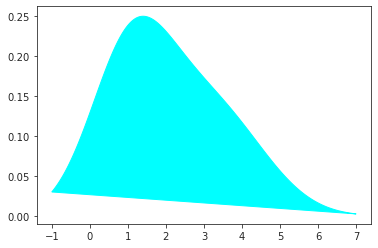

In [66]:
plt.fill(x_test, np.exp(log_dens), c='cyan')
plt.show()

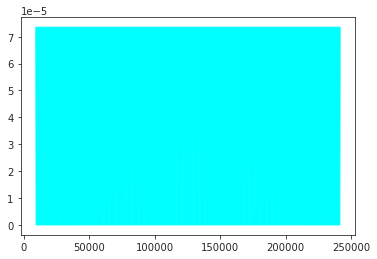

In [103]:
x_train = hist[1].reshape(-1, 1)
x_test = np.linspace(hist[1].min(), hist[1].max(), 1000).reshape(-1, 1)

model = KernelDensity(kernel='epanechnikov', bandwidth=200)
model.fit(x_train)
log_dens = model.score_samples(x_test)

plt.fill(x_test, np.exp(log_dens), c='cyan')
plt.show()

### Calculate density contrast

In [68]:
contrast_density = zz_without_borders/mode1

In [69]:
ra_vir = np.array([159.17, 157.51, 160.14])
dec_vir = np.array([-27.52, -35.32, -46.19])
radius_vir = np.array([1.5744, 1.37, 0.530])

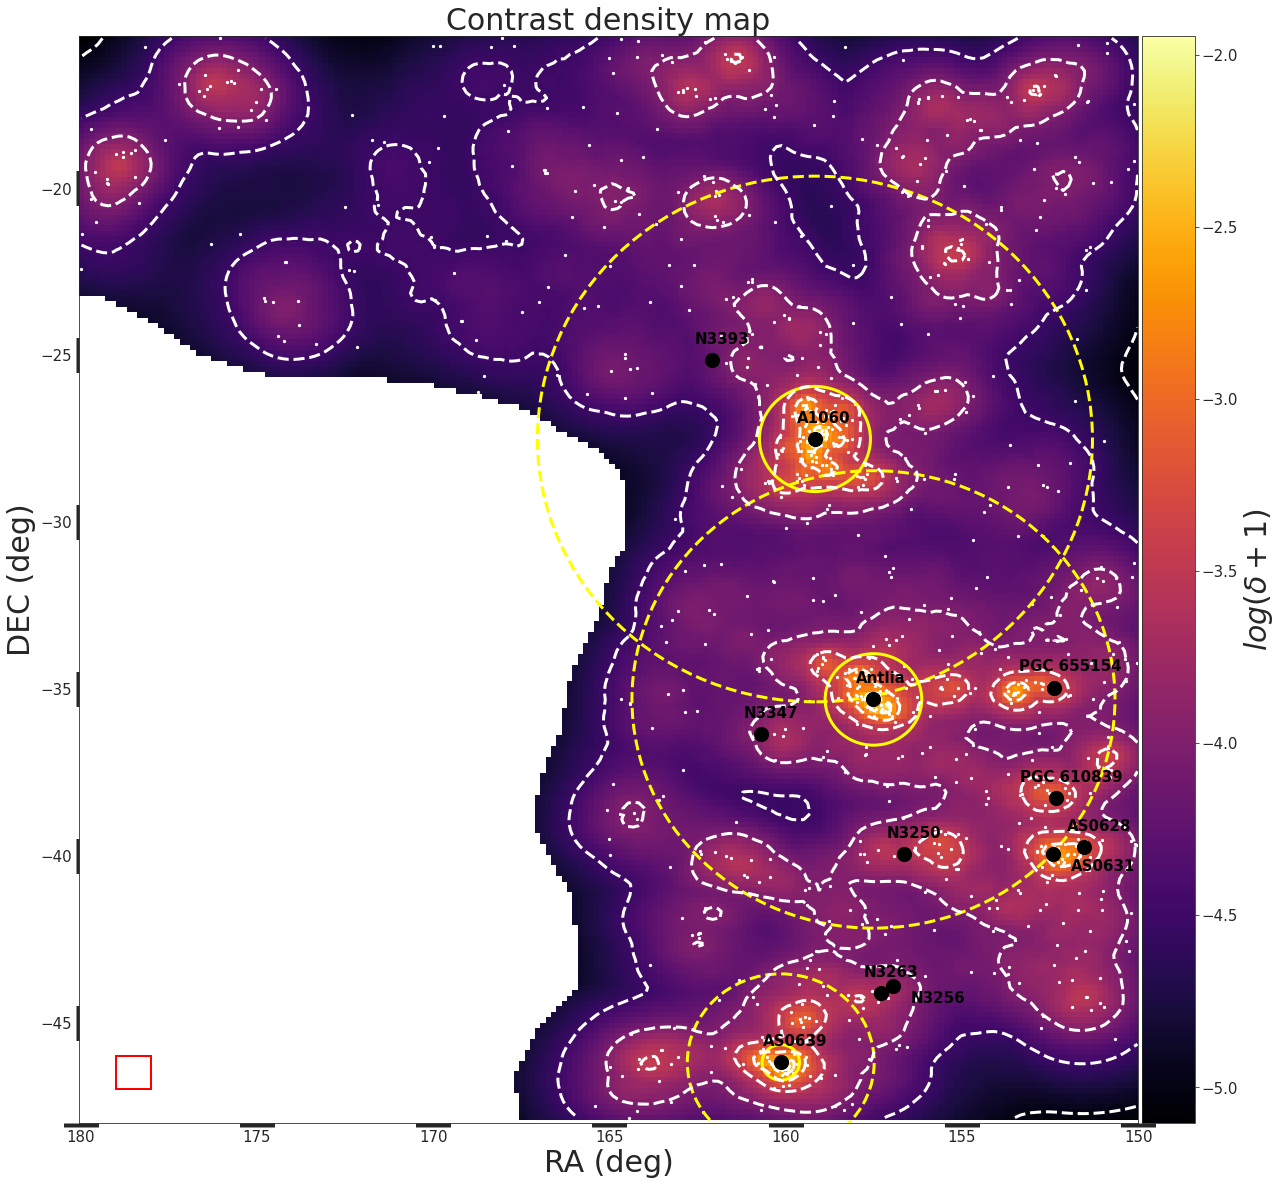

In [70]:
fontsize = 30
labelsize = 15

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
sc1 = ax.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), np.log10(contrast_density/conversion_factor), cmap='inferno')
ax.contour(np.rad2deg(xx), np.rad2deg(yy), np.log10(contrast_density/conversion_factor), colors='white', levels=6, extend='min', linewidths=3)
ax.scatter(np.rad2deg(x), np.rad2deg(y), s=5, color='white')
ax.set_ylabel("DEC (deg)", fontsize=fontsize)
ax.set_xlabel("RA (deg)", fontsize=fontsize)
ax.set_title("Contrast density map".format(mlim, K), fontsize=fontsize)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label=r"$log(\delta + 1)$", fontsize=fontsize)
cbar.ax.tick_params(labelsize=labelsize)

ax.xaxis.set_tick_params(labelsize=labelsize, width=35)
ax.yaxis.set_tick_params(labelsize=labelsize, width=35)

dx = 0.5
for ra_i, dec_i, text in zip(cl_ras[mask], cl_decs[mask], cl_names[mask]):
    ax.scatter(ra_i, dec_i, marker='o', s = 200, color="black", zorder=3)
    if (text == "N3256") | (text == "AS0631"): 
        ax.text(ra_i-dx, dec_i-dx, s=text, fontsize=labelsize, fontweight='bold', color='black', zorder=4)
    else: 
        ax.text(ra_i+dx, dec_i+dx, s=text, fontsize=labelsize, fontweight='bold', color='black', zorder=4)

    
rect = patches.Rectangle((178, -47), 1, 1, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)


for ra_0, dec_0, radius in zip(ra_vir, dec_vir, radius_vir):
    FiveR200 = plt.Circle((ra_0, dec_0), 5*radius, linestyle='--', 
                          edgecolor='yellow', facecolor="None", lw=3, label=r'$5 r_{200} = 7.872^{\circ}$')
    ax.add_patch(FiveR200)

    OneR200 = plt.Circle((ra_0, dec_0), radius, linestyle='-', 
                         edgecolor='yellow', facecolor="None", lw=3, label=r'$1 r_{200} = 1.5744^{\circ}$')
    ax.add_patch(OneR200)
    
    
ax.scatter(ra_gal1, dec_gal1, marker='o', s = 200, color="black", zorder=3)
ax.text(ra_gal1+2*dx, dec_gal1+dx, s="PGC 610839", fontsize=labelsize, fontweight='bold', color='black', zorder=4)

ax.scatter(ra_gal2, dec_gal2, marker='o', s = 200, color="black", zorder=3)
ax.text(ra_gal2+2*dx, dec_gal2+dx, s="PGC 655154", fontsize=labelsize, fontweight='bold', color='black', zorder=4)
    
    
ax.set_ylim(-48)
ax.set_xlim(150)
ax.invert_xaxis()